# Initialization

In [1]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
from matplotlib import pyplot as plt
import matplotlib
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_work_dir_path = os.path.split(os.path.split(os.path.split(os.path.dirname(os.path.realpath("__file__")))[0])[0])[0]
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = '/'.join([prefix, 'workdir3'])
s3_saves_dir_path = '/'.join([s3_work_dir_path , 'model_saves'])
s3_data_dir_path = '/'.join([s3_work_dir_path , 'data'])
s3_data_ver_dir_path = '/'.join([s3_data_dir_path,'100K_V4'])

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

In [2]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
perplexity = 5

# Load

## dataset

In [3]:
X = from_s3_npy(s3_client, bucket_name, '/'.join([s3_data_ver_dir_path, 'X_test_set.npy']))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/X_test_set.npy


In [4]:
wl_grid = from_s3_npy(s3_client, bucket_name, '/'.join([s3_data_ver_dir_path, 'wl_100K_V4.npy']))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/wl_100K_V4.npy


In [5]:
gs = from_s3_pkl(s3_client, bucket_name, '/'.join([s3_data_ver_dir_path,'gs_test_V4.pkl']))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/gs_test_V4.pkl


In [6]:
snr = gs.snMedian.tolist()

## RF

In [7]:
D_RF = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/dist_mat_hat_test_set.npy')

loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/dist_mat_hat_test_set.npy


In [8]:
RF_weird_scores = np.mean(D_RF, axis=1)

In [9]:
RF_sne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', verbose=1, random_state=seed).fit_transform(D_RF)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.177s...
[t-SNE] Computed neighbors for 10000 samples in 2.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.046980
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.571976
[t-SNE] KL divergence after 1000 iterations: 3.323006


### Plotting TSNE

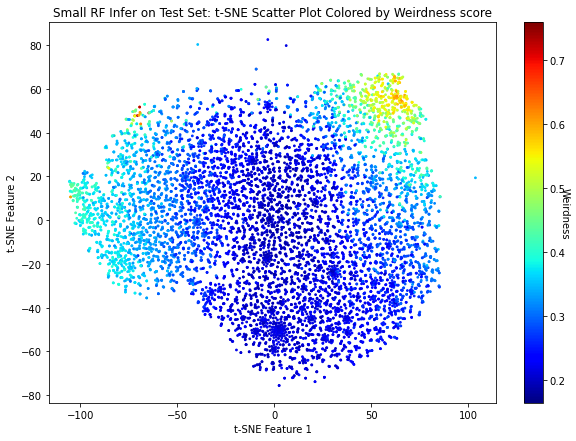

In [10]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(RF_sne[:,0], RF_sne[:,1], s=3, c=RF_weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r'Small RF Infer on Test Set: t-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

In [11]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/tsne_colored_by_weirdness-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/tsne_colored_by_weirdness-test_set.png


True

### Scores Histogram

Text(0.5, 0, 'weirdness score')

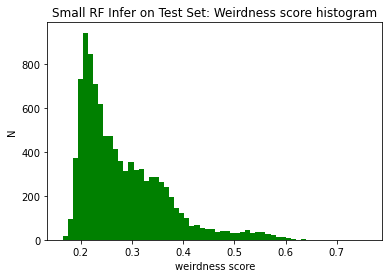

In [12]:
fig = plt.figure()
tmp = plt.hist(RF_weird_scores, bins=60, color="g")
plt.title("Small RF Infer on Test Set: Weirdness score histogram")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [13]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/weirdness_scores_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/weirdness_scores_histogram-test_set.png


True

### Distances Histogram

In [14]:
distances = D_RF[np.tril_indices(D_RF.shape[0], -1)]

Text(0.5, 0, 'distance')

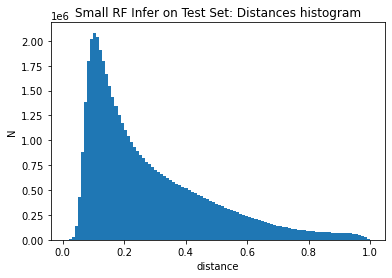

In [15]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("Small RF Infer on Test Set: Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

In [16]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/distances_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/distances_histogram-test_set.png


True

In [17]:
del D_RF, distances

## NN

In [18]:
Z_NN = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy')

loading from uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy


In [19]:
# Loading Z - the upper triangular part of the distance matrices - and recreating the distances matrix
N = int((-1+np.sqrt(1+8*len(Z_NN)))/2)
D_NN = np.zeros(shape=(N,N))
D_NN[np.triu_indices(N)] = Z_NN
D_NN = D_NN.T
D_NN[np.triu_indices(N)] = Z_NN

In [20]:
del Z_NN

In [21]:
# calculating weirdness scores and t-SNE
NN_weird_scores = np.mean(D_NN, axis=1)
NN_sne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', verbose=1, random_state=seed).fit_transform(D_NN)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.396s...
[t-SNE] Computed neighbors for 10000 samples in 8.810s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.057954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 151.691406
[t-SNE] KL divergence after 1000 iterations: 4.346707


### Plotting TSNE

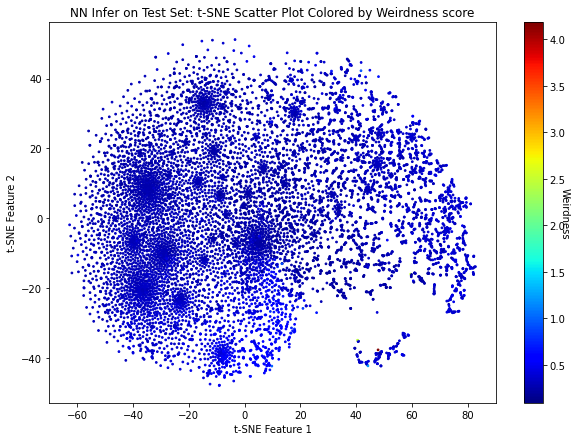

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(NN_sne[:,0], NN_sne[:,1], s=3, c=NN_weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r'NN Infer on Test Set: t-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

In [23]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png


True

### Scores Histogram

Text(0.5, 0, 'weirdness score')

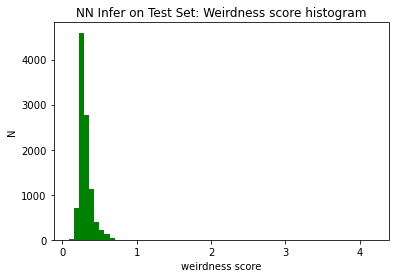

In [24]:
fig = plt.figure()
tmp = plt.hist(NN_weird_scores, bins=60, color="g")
plt.title("NN Infer on Test Set: Weirdness score histogram")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [25]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-test_set.png


True

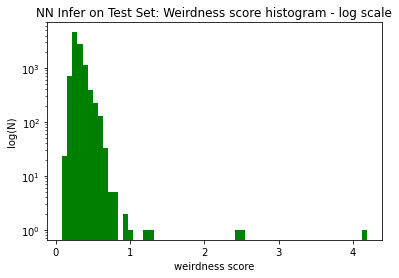

In [26]:
fig = plt.figure()
tmp = plt.hist(NN_weird_scores, bins=60, color="g")
plt.title("NN Infer on Test Set: Weirdness score histogram - log scale")
plt.ylabel("log(N)")
plt.xlabel("weirdness score")
plt.yscale('log')

In [27]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-log-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-log-test_set.png


True

### Distances Histogram

In [28]:
distances = D_NN[np.tril_indices(D_NN.shape[0], -1)]

Text(0.5, 0, 'distance')

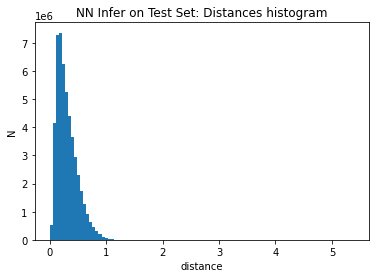

In [29]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN Infer on Test Set: Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

In [30]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png


True

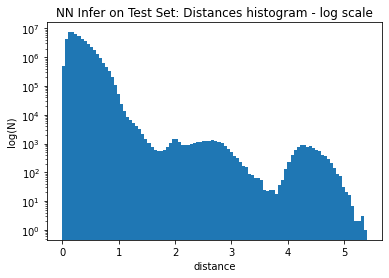

In [31]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN Infer on Test Set: Distances histogram - log scale")
plt.ylabel("log(N)")
plt.xlabel("distance")
plt.yscale('log')

In [32]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png


True

In [33]:
del D_NN, distances

## NN + AWGN

In [34]:
Z_NN_AWGN = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy')

loading from uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy


In [35]:
# Loading Z - the upper triangular part of the distance matrices - and recreating the distances matrix
N = int((-1+np.sqrt(1+8*len(Z_NN_AWGN)))/2)
D_NN_AWGN = np.zeros(shape=(N,N))
D_NN_AWGN[np.triu_indices(N)] = Z_NN_AWGN
D_NN_AWGN = D_NN_AWGN.T
D_NN_AWGN[np.triu_indices(N)] = Z_NN_AWGN

In [36]:
del Z_NN_AWGN

In [37]:
# calculating weirdness scores and t-SNE
NN_AWGN_weird_scores = np.mean(D_NN_AWGN, axis=1)
NN_AWGN_sne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', verbose=1, random_state=seed).fit_transform(D_NN_AWGN)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.226s...
[t-SNE] Computed neighbors for 10000 samples in 5.251s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.043447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 144.774185
[t-SNE] KL divergence after 1000 iterations: 4.094184


### Plotting TSNE

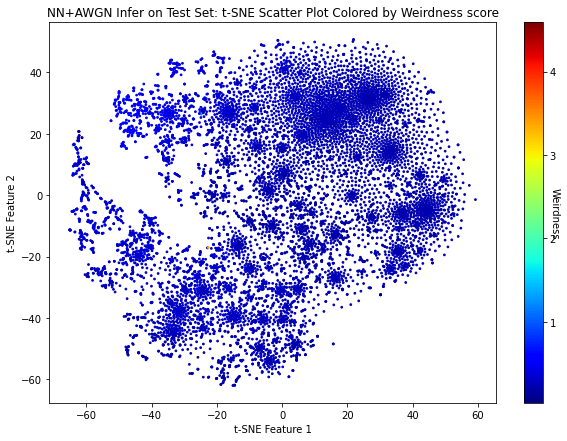

In [38]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(NN_AWGN_sne[:,0], NN_AWGN_sne[:,1], s=3, c=NN_AWGN_weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r'NN+AWGN Infer on Test Set: t-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

In [39]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png


True

### Scores Histogram

Text(0.5, 0, 'weirdness score')

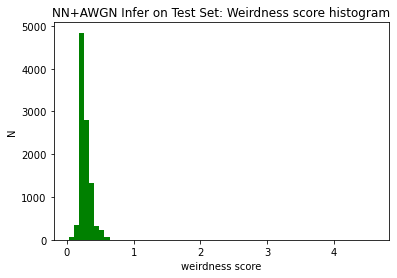

In [40]:
fig = plt.figure()
tmp = plt.hist(NN_AWGN_weird_scores, bins=60, color="g")
plt.title("NN+AWGN Infer on Test Set: Weirdness score histogram")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [41]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-test_set.png


True

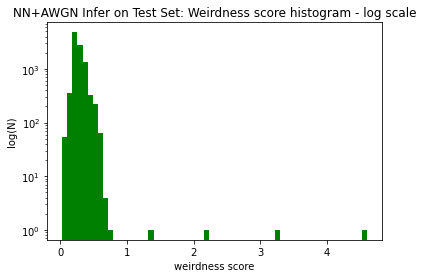

In [42]:
fig = plt.figure()
tmp = plt.hist(NN_AWGN_weird_scores, bins=60, color="g")
plt.title("NN+AWGN Infer on Test Set: Weirdness score histogram - log scale")
plt.ylabel("log(N)")
plt.xlabel("weirdness score")
plt.yscale('log')

In [43]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-log-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-log-test_set.png


True

### Plotting Distances

In [44]:
distances = D_NN_AWGN[np.tril_indices(D_NN_AWGN.shape[0], -1)]

Text(0.5, 0, 'distance')

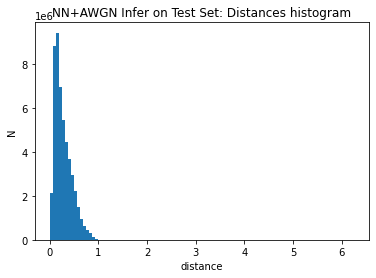

In [45]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN+AWGN Infer on Test Set: Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

In [46]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png


True

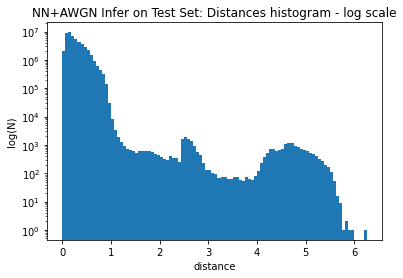

In [47]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN+AWGN Infer on Test Set: Distances histogram - log scale")
plt.ylabel("log(N)")
plt.xlabel("distance")
plt.yscale('log')

In [48]:
to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png


True

In [49]:
del D_NN_AWGN, distances